# 1. import libraries and get data from Quandl

In [1]:
# import libraries
import quandl
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import os
import statsmodels.api as sm
import warnings 

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight') # this is a styling option

In [2]:
quandl.ApiConfig.api_key = 'PXZ_xqzefyZZftfrpG3V'

In [3]:
# import the data 'Real potential gross domestic product' FRED/GDPPOT
data = quandl.get('FRED/GDPPOT')

In [4]:
data.head(3)

,Value
Date,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530


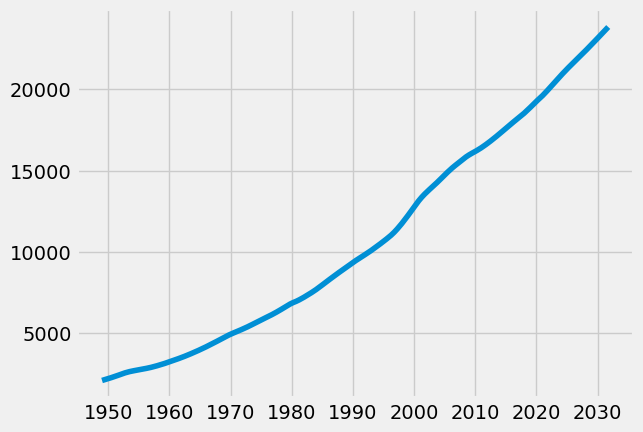

In [5]:
plt.plot(data)

In [6]:
data.shape

(332, 1)

In [7]:
data2 = data.reset_index()

In [8]:
data2.head(3)

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530


# 2. Data preprocessing

## 2.1 Get subset

In [9]:
# considering that the data was refreshed in 2021, we will take a subset of this data： only keep the years that are <= 2020
d_sub = data2.loc[data2['Date']< '2021-01-01']

In [10]:
d_sub.tail()

,Date,Value
283,2019-10-01,19157.14
284,2020-01-01,19250.22
285,2020-04-01,19340.19
286,2020-07-01,19424.19
287,2020-10-01,19512.02


In [11]:
# set the 'Date' as the index
from datetime import datetime

d_sub['datetime'] = pd.to_datetime(d_sub['Date'])
d_sub = d_sub.set_index('datetime')
d_sub.drop(['Date'], axis = 1, inplace = True)
d_sub.head()

,Value
datetime,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


In [12]:
d_sub.head()

,Value
datetime,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


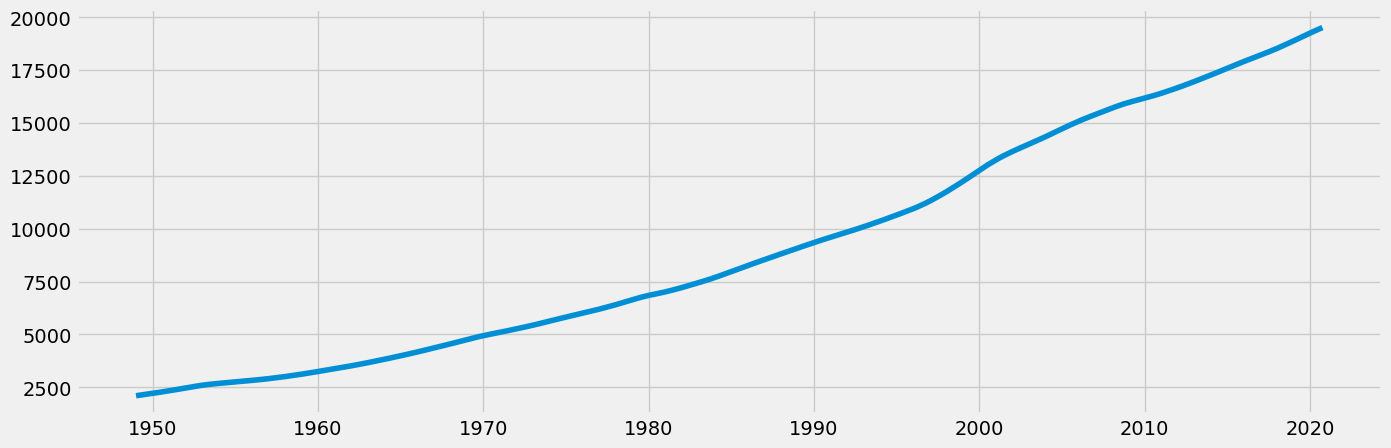

In [13]:
# plot the d_sub

plt.figure(figsize = (15,5), dpi = 100)
plt.plot(d_sub)

## 2.2 Data consistency check

### Missing data check

In [14]:
d_sub.isnull().sum()

Value    0
dtype: int64

## Duplicated check

In [15]:
d_sub[d_sub.duplicated()]

,Value
datetime,


### Mixed datatype check

In [16]:
for col in d_sub.columns.tolist():
    wierd =(d_sub[[col]].applymap(type) != d_sub[[col]].iloc[0].apply(type)).any(axis = 1)
    if len(d_sub[wierd]) > 0:
        print(col)

### Extreme records

<AxesSubplot:ylabel='Frequency'>

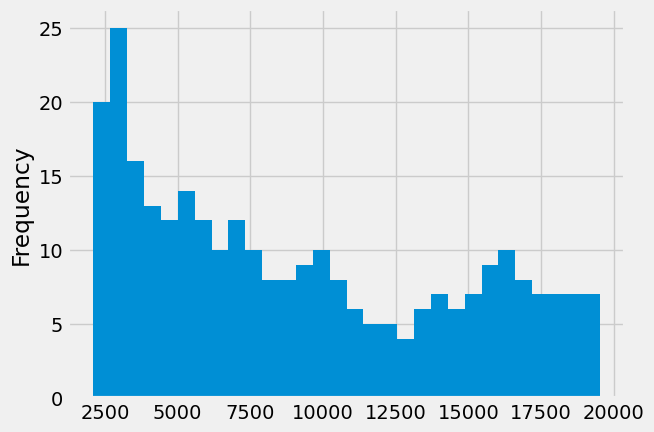

In [17]:
d_sub['Value'].plot.hist(bins = 30)

### * Conclusions: No nulls, no duplicates, no mixed types and no extreme records

# 3. Time-series analysis

## 3.1 Time series decomposition

### The 'Additive model' is adopted based on the linechart above

In [18]:
decom = sm.tsa.seasonal_decompose(d_sub,model = 'additive')

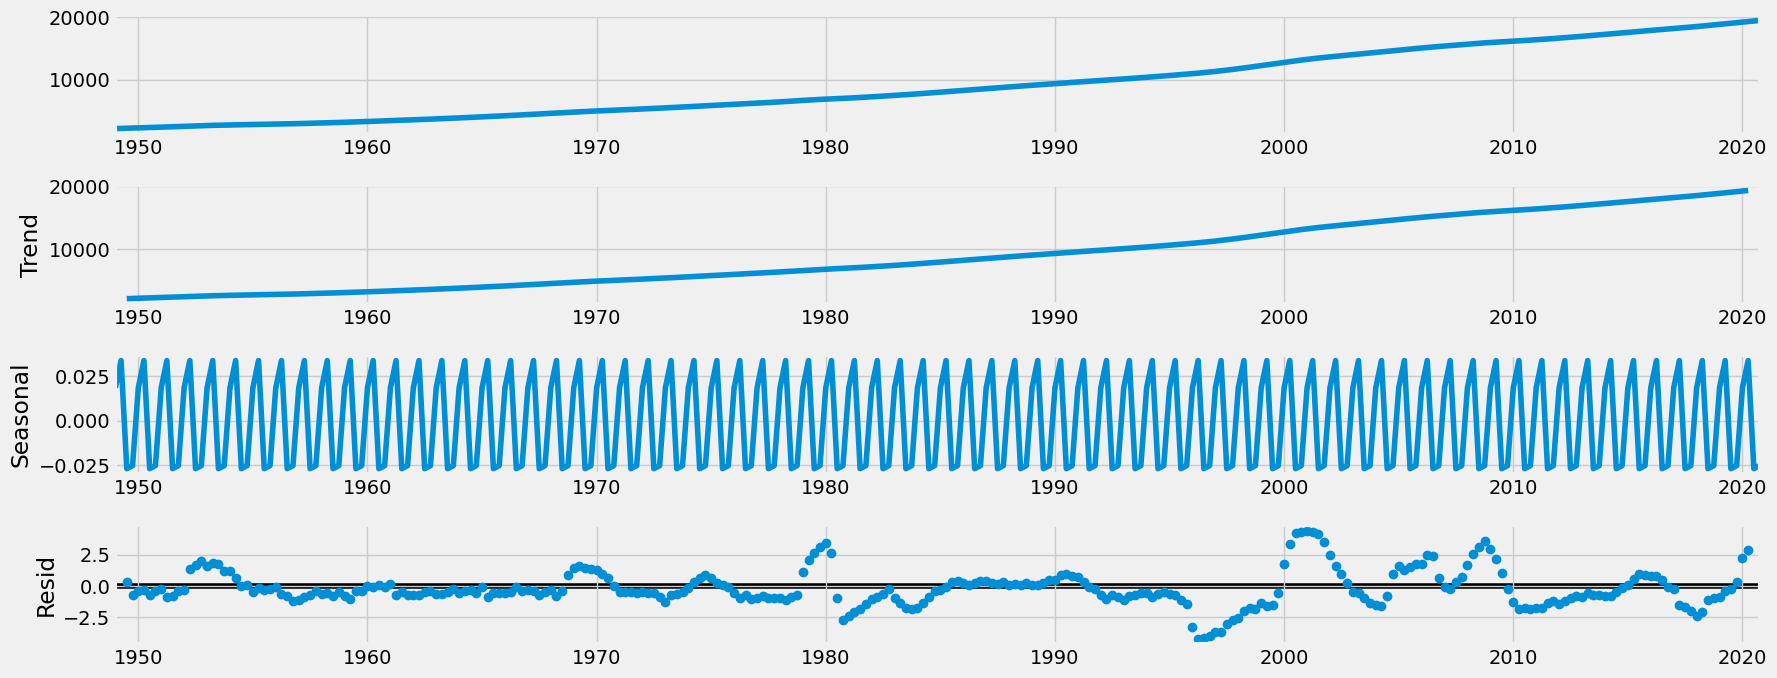

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7 # set size for all the figures

decom.plot()
plt.show()

## 3.2 Testing for stationarity

### Dickey-Fuller test: 
### Null hypothesis: there are unit roots - nonstationary
### Alternative hypothesis: there are no unit roots  - statitoary

In [20]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag = 'AIC')
    result = pd.Series(test[0:4],index = ['Test Statistic','p-value','Number of lags used','Number of observations used'])
    for key, value in test[4].items():
        result['Critical Value (%s)' %key] = value
    print (result)

In [21]:
dickey_fuller(d_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.509236
p-value                          0.999053
Number of lags used              2.000000
Number of observations used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


### From the p-value, it is concluded that this time series is not stationary

## 3.3 Testing for Autocorrelation

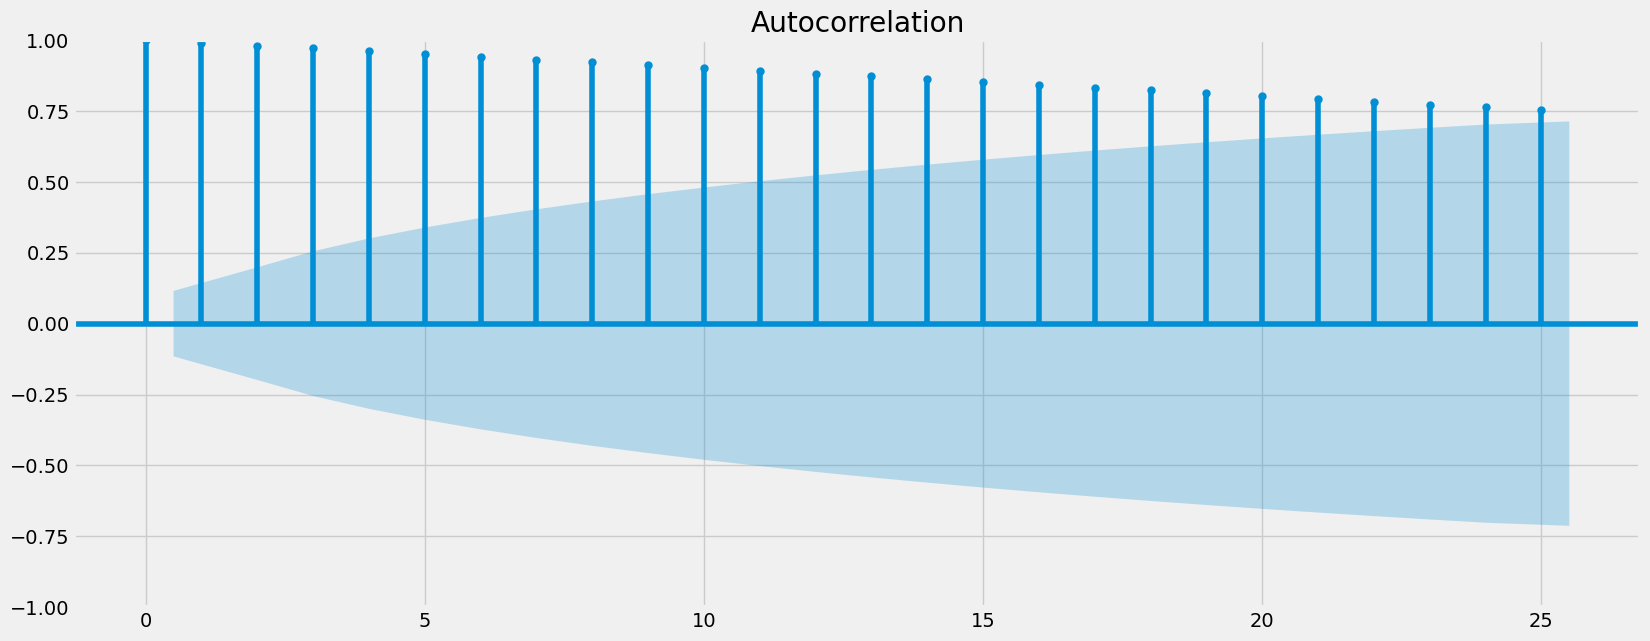

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(d_sub)
plt.show()


### The lags are all out of the confidence interval: there exist autocorrelations

## 3.4 Stationarizing the time series

### Applying the 'difference' technique

In [23]:
data_diff = d_sub - d_sub.shift(1)

In [24]:
data_diff.dropna(inplace = True)

In [25]:
data_diff.head()

,Value
datetime,
1949-04-01,27.598675
1949-07-01,28.759225
1949-10-01,27.504329
1950-01-01,29.213500
1950-04-01,29.423311


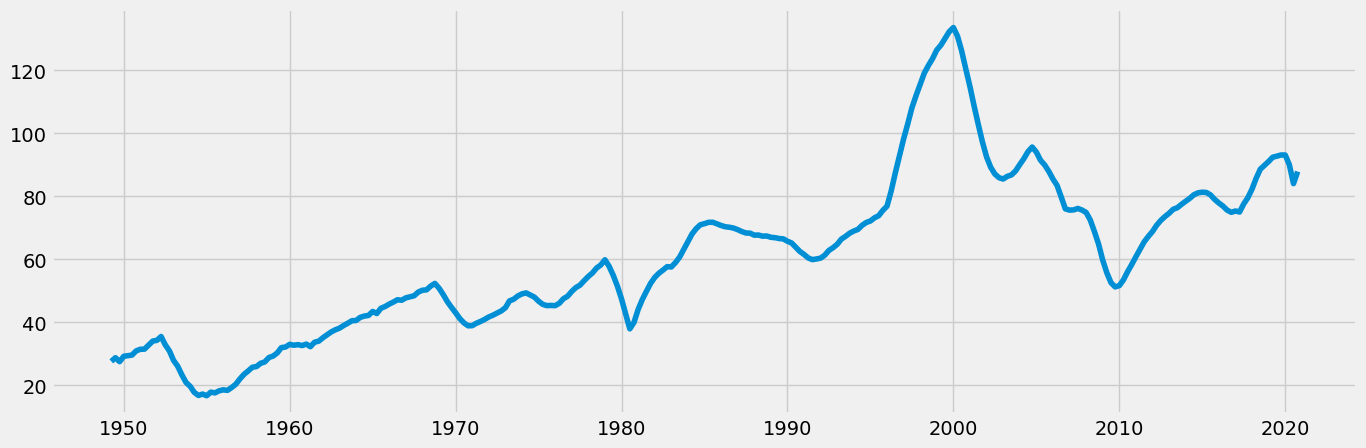

In [26]:
plt.figure(figsize =(15, 5), dpi =100)
plt.plot(data_diff)

In [27]:
# dickey-fuller check
dickey_fuller(data_diff['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.445107
p-value                          0.560471
Number of lags used              4.000000
Number of observations used    282.000000
Critical Value (1%)             -3.453754
Critical Value (5%)             -2.871844
Critical Value (10%)            -2.572261
dtype: float64


### The p-value is still bigger than 0.05, therefore we need further steps for stationarizing

In [28]:
data_diff_2 = data_diff - data_diff.shift(1)

In [29]:
data_diff_2.dropna(inplace = True)

In [30]:
dickey_fuller(data_diff_2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                -5.939260e+00
p-value                        2.281530e-07
Number of lags used            3.000000e+00
Number of observations used    2.820000e+02
Critical Value (1%)           -3.453754e+00
Critical Value (5%)           -2.871844e+00
Critical Value (10%)          -2.572261e+00
dtype: float64


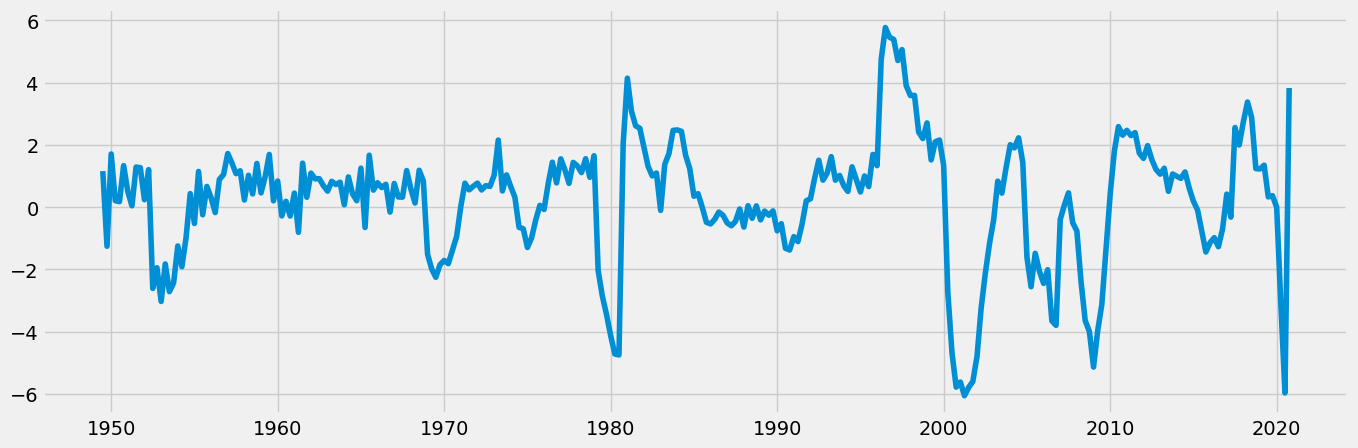

In [31]:
plt.figure(figsize = (15, 5), dpi = 100)
plt.plot(data_diff_2)

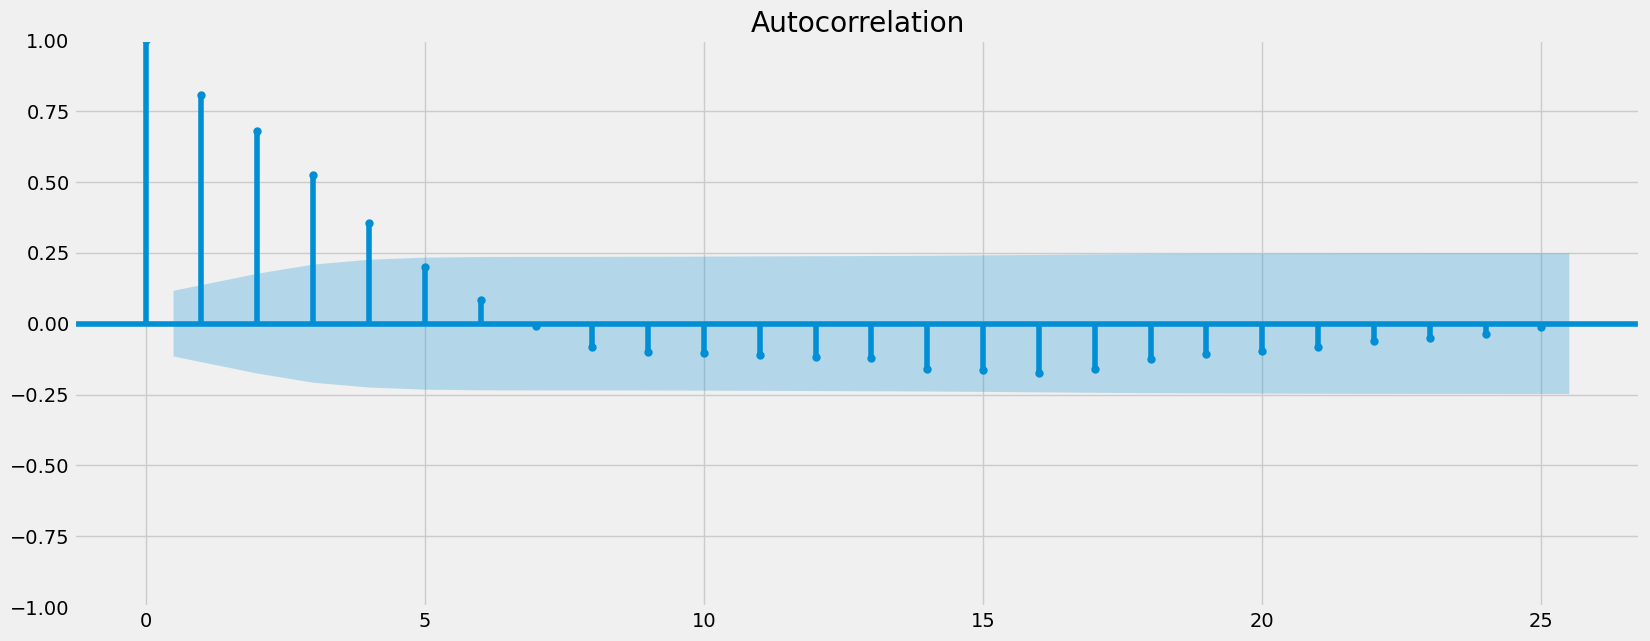

In [32]:
plot_acf(data_diff_2)
plt.show()

### Conclusions: data_diff_2 is stationary
#### 1) p-value < 0.05
#### 2) there are less than 10 lags that are out of the confidenece interval